In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F 
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from livelossplot import PlotLosses

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Обработка датасета
Загружаем исходный датасет, увеличиваем его в 5 раз применяя аугментацию (в нашем случае - случайный поворот буквы в пределах от 0 до 360 градусов и случайная обрезка изображения, которая позволяет изменить положение буквы, а также соотношение сторон в пределах (от 0.7 до 1).

In [2]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()])

augment_transform = v2.Compose(
    [transform, 
     v2.RandomRotation((0, 360)), 
     v2.RandomResizedCrop((32, 32), (0.85, 1), (0.7, 1))])

orig_set = torchvision.datasets.ImageFolder(root='./dataset/data_no_affine/', transform=transform)

set_1 = torchvision.datasets.ImageFolder(root='./dataset/data_no_affine/', transform=augment_transform)
set_2 = torchvision.datasets.ImageFolder(root='./dataset/data_no_affine/', transform=augment_transform)
set_3 = torchvision.datasets.ImageFolder(root='./dataset/data_no_affine/', transform=augment_transform)
set_4 = torchvision.datasets.ImageFolder(root='./dataset/data_no_affine/', transform=augment_transform)

orig_set += set_1 + set_2 + set_3 + set_4

Делим датасет на обучающий, валидационный и тестовый в соотношении 80%, 10%, 10% соответсвенно. При этом перемешиваем обучающий датасет. Выберем batch size = 8.

In [3]:
val_size = int(0.1 * len(orig_set))
test_size = int(0.1 * len(orig_set))
train_size = len(orig_set) - val_size - test_size

trainset, valset, testset = torch.utils.data.random_split(orig_set, [train_size, val_size, test_size])

batch_size = 8


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader
}

len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(28669, 3583, 3583)

# Сверточная нейронная сеть
Создаем класс сверточной нейронной сети

In [4]:
class PNebaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Нейросеть имеет следующую структуру:

In [5]:
model = PNebaNet()

summary(model.to(device), input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
PNebaNet                                 [1, 36]                   --
├─Conv2d: 1-1                            [1, 64, 28, 28]           1,664
├─MaxPool2d: 1-2                         [1, 64, 14, 14]           --
├─Conv2d: 1-3                            [1, 128, 12, 12]          73,856
├─MaxPool2d: 1-4                         [1, 128, 6, 6]            --
├─Linear: 1-5                            [1, 128]                  589,952
├─Linear: 1-6                            [1, 64]                   8,256
├─Linear: 1-7                            [1, 36]                   2,340
Total params: 676,068
Trainable params: 676,068
Non-trainable params: 0
Total mult-adds (M): 12.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 2.70
Estimated Total Size (MB): 3.26

Функция обучения нейросети с выводом графиков и статистики обучения

In [6]:
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch {epoch} {phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()
    print("End")

Для обучения используется оптимизатор Adam и кросс-энтропийная функция потерь. Обучаем 10 эпох. learning rate = 0.0001

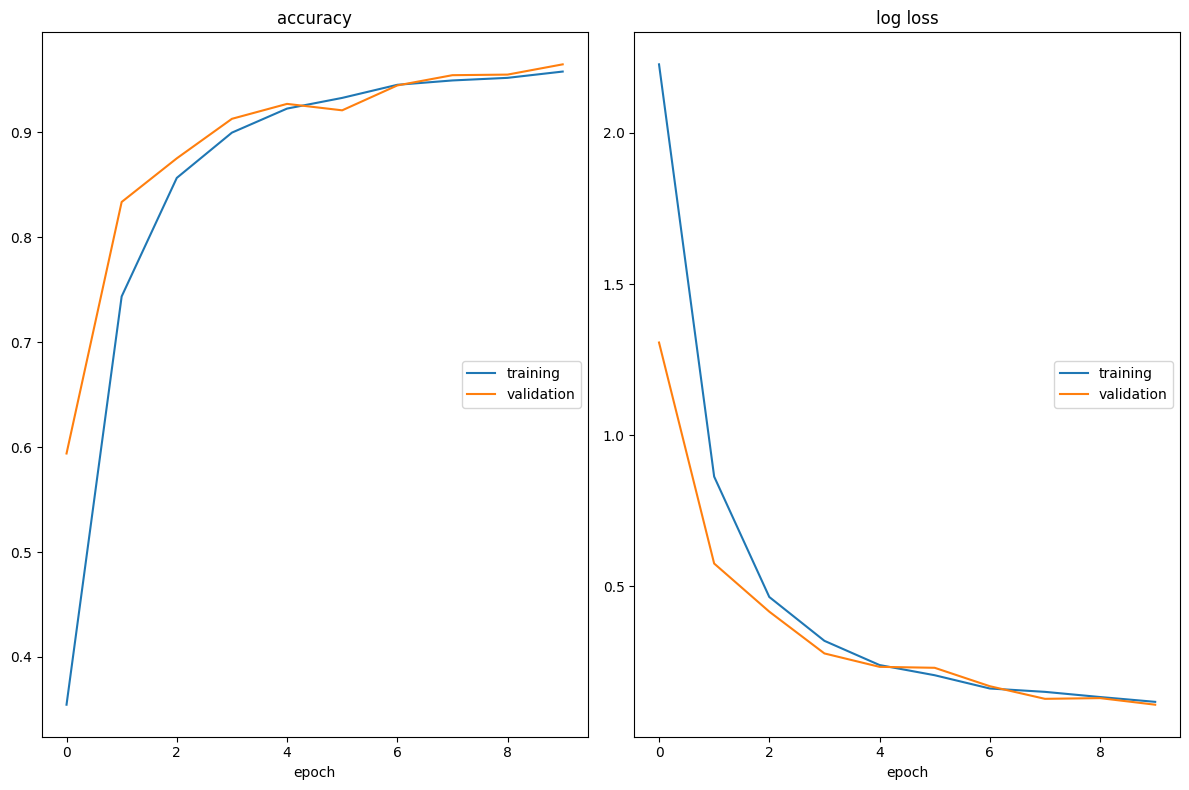

accuracy
	training         	 (min:    0.354, max:    0.958, cur:    0.958)
	validation       	 (min:    0.594, max:    0.965, cur:    0.965)
log loss
	training         	 (min:    0.118, max:    2.227, cur:    0.118)
	validation       	 (min:    0.109, max:    1.307, cur:    0.109)
End


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, criterion, optimizer, num_epochs=10)

Проверим точность обученной нейросети для каждого класса на тестовом датасете:

In [8]:
classes = tuple(str(i) for i in range(36))
class_correct = list(0. for i in range(36))
class_total = list(0. for i in range(36))

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        y_pred = model(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        
        
        c = (predicted.cpu().detach() == labels)
        for i in range(len(images)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(36):

    print('Accuracy of %5s : %5f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98.958333 %
Accuracy of     1 : 100.000000 %
Accuracy of     2 : 100.000000 %
Accuracy of     3 : 95.959596 %
Accuracy of     4 : 91.818182 %
Accuracy of     5 : 86.813187 %
Accuracy of     6 : 98.260870 %
Accuracy of     7 : 98.148148 %
Accuracy of     8 : 98.347107 %
Accuracy of     9 : 95.789474 %
Accuracy of    10 : 92.156863 %
Accuracy of    11 : 100.000000 %
Accuracy of    12 : 100.000000 %
Accuracy of    13 : 95.535714 %
Accuracy of    14 : 99.082569 %
Accuracy of    15 : 98.214286 %
Accuracy of    16 : 97.701149 %
Accuracy of    17 : 100.000000 %
Accuracy of    18 : 100.000000 %
Accuracy of    19 : 100.000000 %
Accuracy of    20 : 100.000000 %
Accuracy of    21 : 97.849462 %
Accuracy of    22 : 95.744681 %
Accuracy of    23 : 90.476190 %
Accuracy of    24 : 99.019608 %
Accuracy of    25 : 99.082569 %
Accuracy of    26 : 98.823529 %
Accuracy of    27 : 98.958333 %
Accuracy of    28 : 63.736264 %
Accuracy of    29 : 96.551724 %
Accuracy of    30 : 98.924731 %


Видим хорошую точность предсказаний нейросети, за исключением класса 28. Наиболее вероятной причиной, является то, что буква относящаяся к этому классу является перевернутой буквой из класса 23.

Сохраняем обученную модель в двух форматах:

In [9]:
torch.save(model, "./models/PNebaNet_v1")

In [10]:
torch.save(model.state_dict(), "./models/PNebaNet_v1_weights")